In [1]:
from sklearn.metrics import *
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from final_models_explainability.get_predictions import *

plt.rcParams['font.family'] = 'cmr10'
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 12

In [ ]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout"

In [ ]:
subject_list = find_subjects_parallel(data_path)
    

In [ ]:
for subject in subject_list:

    subject.data = {}

    # Group
    mapping = {
        'CN': 0,
        'MCI': 1,
    }

    # Get the value of the mapping, -1 if not found
    subject.data['research_group'] = mapping.get(subject.subject_metadata['Research Group'].iloc[0], -1)

    # Cloud
    subject.data['lhcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))
    
    # LR cloud
    subject.data['hcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_Right-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))

    # Volumes
    volume_col = subject.aseg_stats['Volume_mm3']
    volume_col_normalised = volume_col / volume_col.sum() * 1000
    struct_name_col = subject.aseg_stats['StructName']
    
    subject.data['volumes'] = np.array(volume_col_normalised)
    
    subject.data['struct_names'] = np.array(struct_name_col)

    # Scores
    mmse = subject.subject_metadata['MMSE Total Score'].iloc[0]
    gdscale = subject.subject_metadata['GDSCALE Total Score'].iloc[0]
    faq = subject.subject_metadata['FAQ Total Score'].iloc[0]
    npiq = subject.subject_metadata['NPI-Q Total Score'].iloc[0]

    subject.data['scores'] = [mmse, gdscale, faq, npiq]

    subject.data['score_names'] = ['MMSE Total Score', 'GDSCALE Total Score', 'FAQ Total Score', 'NPI-Q Total Score']

In [ ]:
print(f"Total holdout subjects: {len(subject_list)}\n")
print(f"Total CN: {len([subject.data['research_group'] for subject in subject_list if subject.data['research_group'] == 0])}\n")
print(f"Total MCI: {len([subject.data['research_group'] for subject in subject_list if subject.data['research_group'] == 1])}\n")

## Evaluate pointnet

### Production pointnet

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []
attributions_zero_list = []
attributions_mean_list = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pred_class, output, attributions_zero = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        data.append(subject.data['lhcampus_pointcloud_aligned'])

        # Manually run attributions again for mean baseline attributions
        model = pointnet2_cls_msg.get_model(2, normal_channel=False)

        model.load_state_dict(torch.load("final_models_explainability/pointnet.pth", weights_only=True))

        model.eval()

        model.to('cuda')

        input = torch.from_numpy(subject.data['lhcampus_pointcloud_aligned']).type(torch.float32).to('cuda')

        attributions_mean = explain_pointnet(model, input, mode='mean')

        attributions_mean_list.append(attributions_mean)

        attributions_zero_list.append(attributions_zero)

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/pointnet_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data, attributions_zero_list=attributions_zero_list, attributions_mean_list=attributions_mean_list)



              precision    recall  f1-score   support

          CN       0.50      0.75      0.60        60
         MCI       0.82      0.61      0.70       115

    accuracy                           0.66       175
   macro avg       0.66      0.68      0.65       175
weighted avg       0.71      0.66      0.67       175

roc_auc: 0.6793478260869565
specificity: 0.75


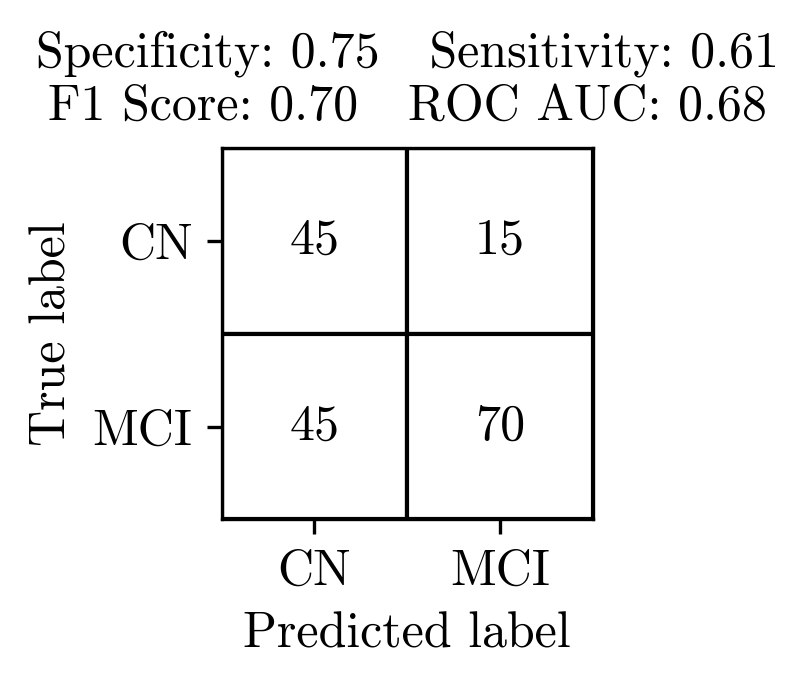

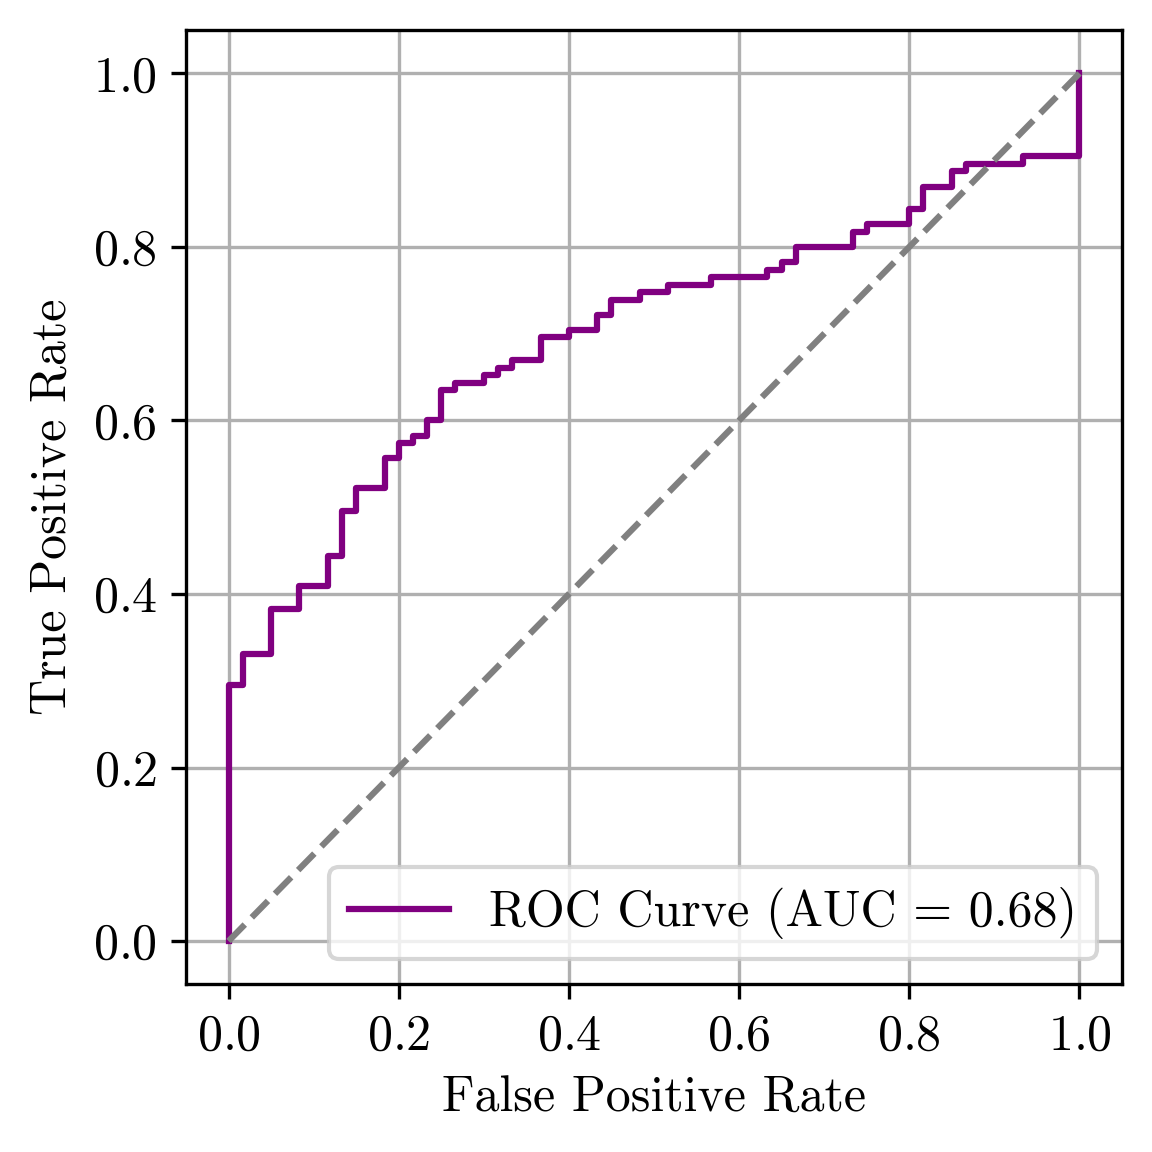

In [2]:
results = np.load('pointnet_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/pointnet_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/pointnet_roc.png', dpi=300)
plt.show()

### LR pointnet for purposes of evaluation

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []
attributions_zero_list = []
attributions_mean_list = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        with torch.no_grad():

            model = pointnet2_cls_msg.get_model(2, normal_channel=False)

            model.load_state_dict(torch.load("lr_pointnet_eval.pth", weights_only=True))

            model.eval()

            model.to('cuda')

            input = subject.data['hcampus_pointcloud_aligned']

            input = torch.from_numpy(input).type(torch.float32).to('cuda')

            attributions_zero = explain_pointnet(model, input, mode='zero')

            attributions_mean = explain_pointnet(model, input, mode='mean')

            # Add batch dim and transpose to 3 x n for pointnet
            input = input.unsqueeze(0).transpose(2, 1)

            # Get output from model, ignoring extra info from pointnet
            output = model(input)[0]

            output = output.squeeze(0)

            # Take negative logits and get probability
            output = torch.nn.functional.softmax(output, dim=0)

            pred_class = int(np.argmax(output.cpu().numpy()))

            output = output.cpu().numpy()

            # Get only the positive class as they add up to 1 anyway
            output = output[1]

            data.append(subject.data['hcampus_pointcloud_aligned'])

            attributions_zero_list.append(attributions_zero)

            attributions_mean_list.append(attributions_mean)

            true.append(subject.data['research_group'])
            
            pred_probs.append(output)

            pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/lr_pointnet_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data, attributions_zero_list=attributions_zero_list, attributions_mean_list=attributions_mean_list)



              precision    recall  f1-score   support

          CN       0.44      0.60      0.51        60
         MCI       0.74      0.61      0.67       115

    accuracy                           0.61       175
   macro avg       0.59      0.60      0.59       175
weighted avg       0.64      0.61      0.62       175

roc_auc: 0.6043478260869566
specificity: 0.6


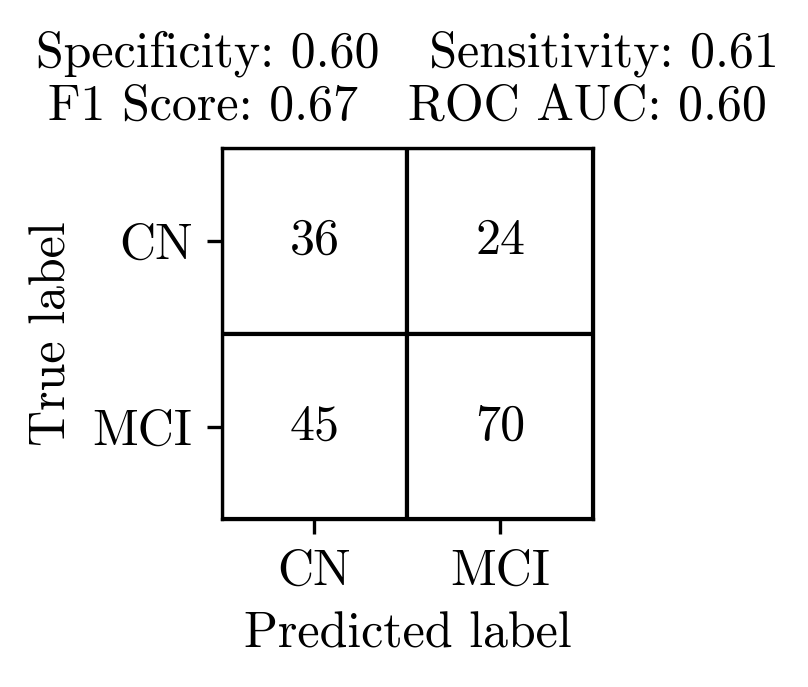

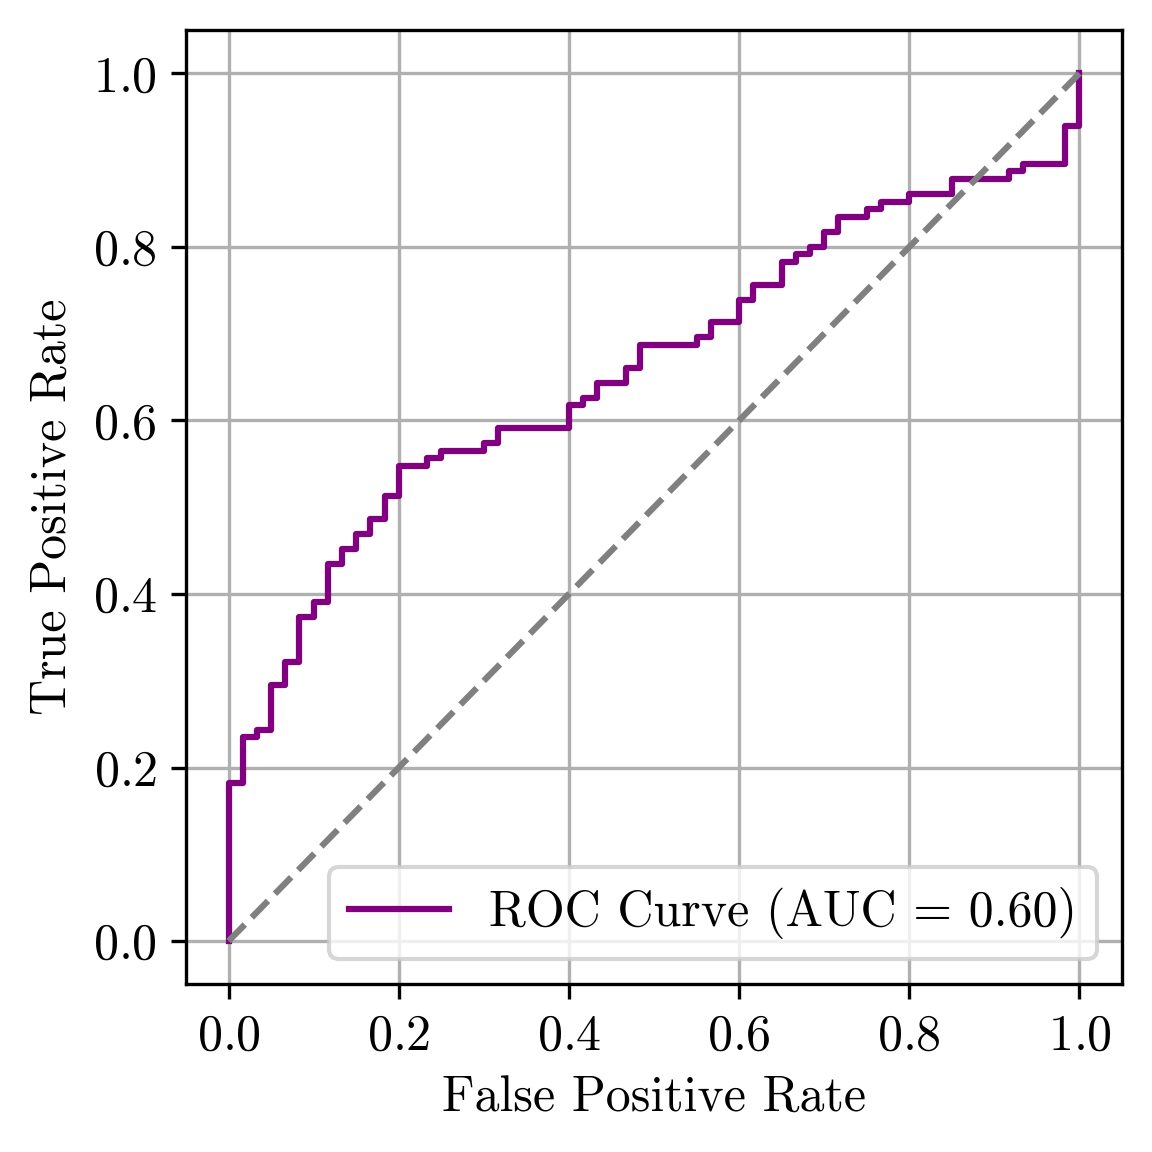

In [3]:
results = np.load('lr_pointnet_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/lr_pointnet_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/lr_pointnet_roc.png', dpi=300)
plt.show()

## Evaluate volumes gbdt

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []
shap_values_list = []

for subject in subject_list:

    pred_class, output, shap_values = get_volumes_prediction(subject.data['volumes'])

    data.append(subject.data['volumes'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

    shap_values_list.append(shap_values)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/volumes_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data, shap_values_list=shap_values_list)

              precision    recall  f1-score   support

          CN       0.54      0.58      0.56        12
         MCI       0.77      0.74      0.76        23

    accuracy                           0.69        35
   macro avg       0.66      0.66      0.66        35
weighted avg       0.69      0.69      0.69        35

roc_auc: 0.661231884057971
specificity: 0.5833333333333334


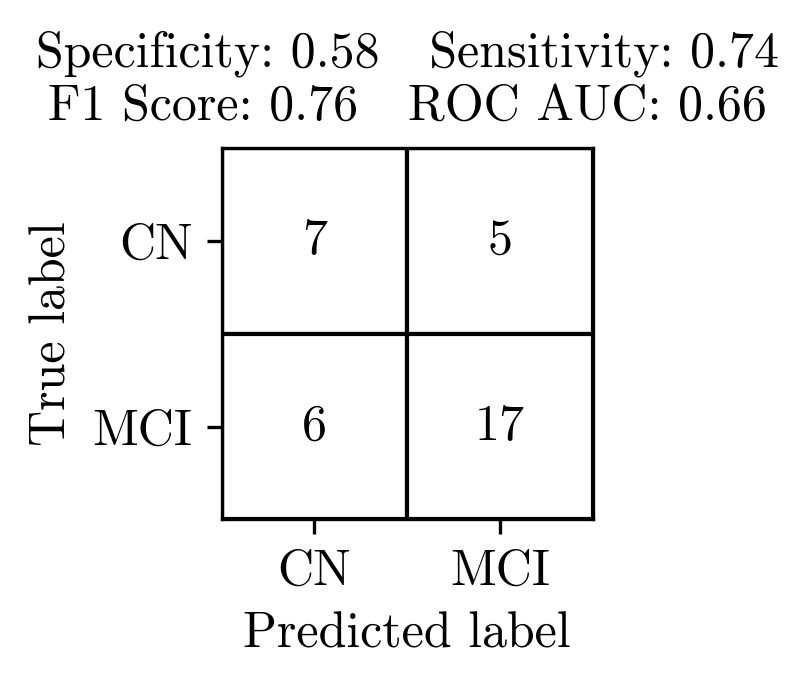

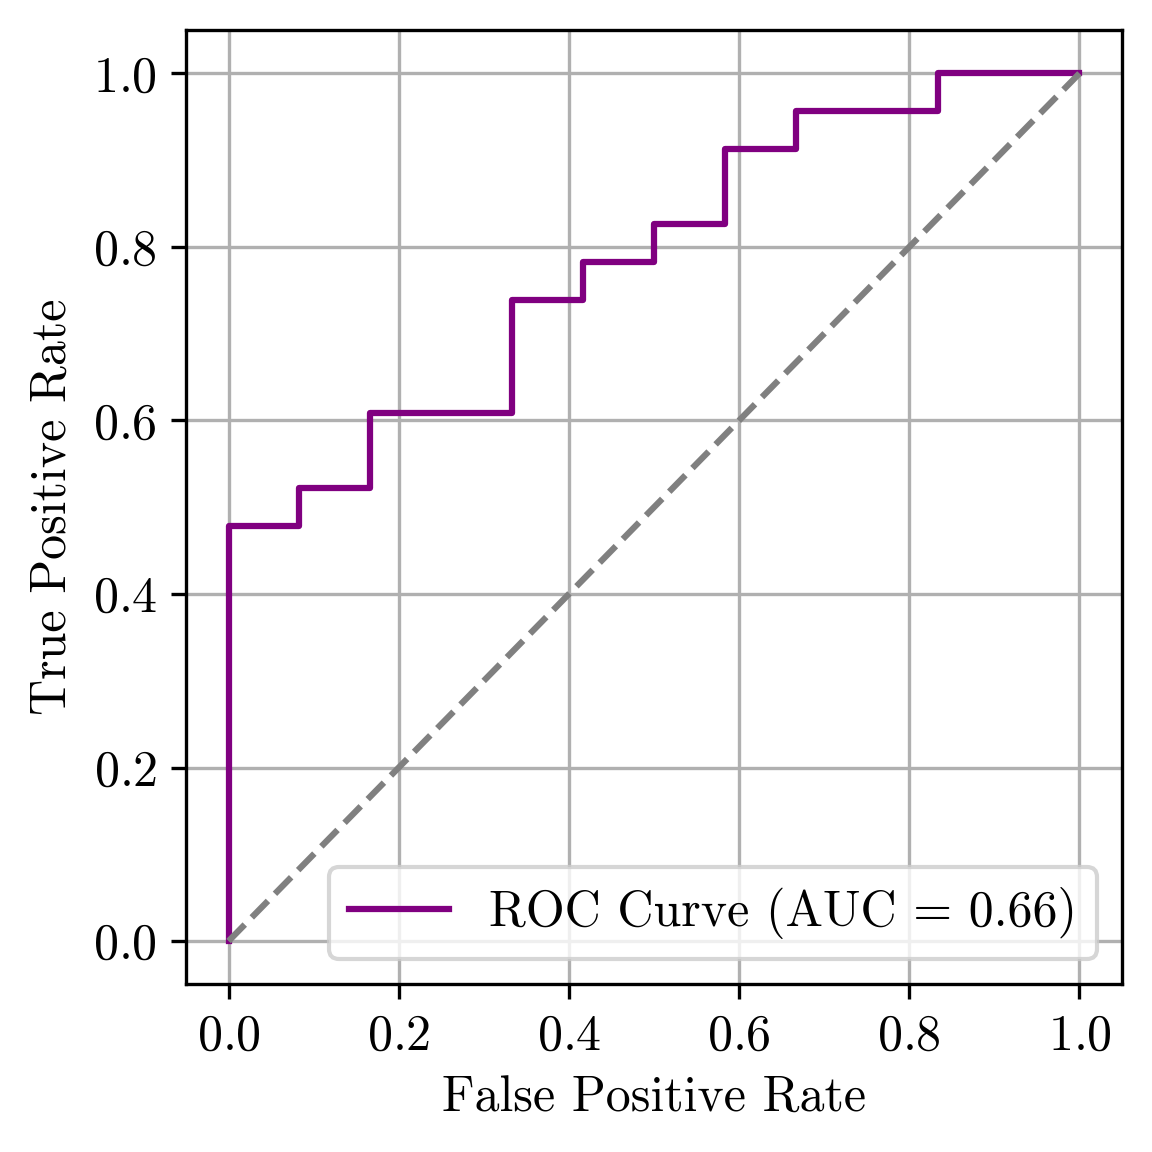

In [4]:
results = np.load('volumes_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/volumes_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/volumes_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluate scores gbdt

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []

for subject in subject_list:

    pred_class, output = get_scores_prediction(subject.data['scores'])

    data.append(subject.data['scores'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scores_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

              precision    recall  f1-score   support

          CN       0.59      0.83      0.69        12
         MCI       0.89      0.70      0.78        23

    accuracy                           0.74        35
   macro avg       0.74      0.76      0.74        35
weighted avg       0.79      0.74      0.75        35

roc_auc: 0.7644927536231885
specificity: 0.8333333333333334


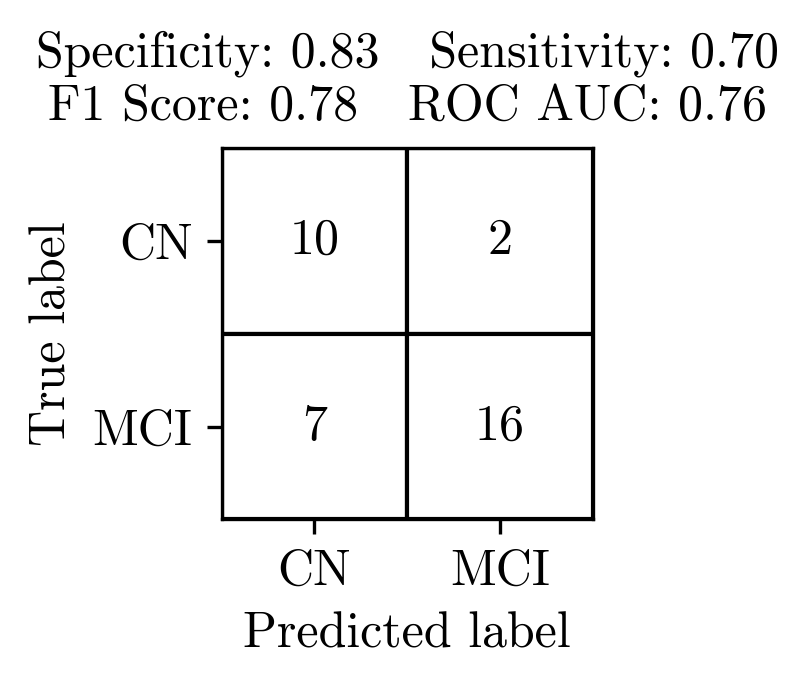

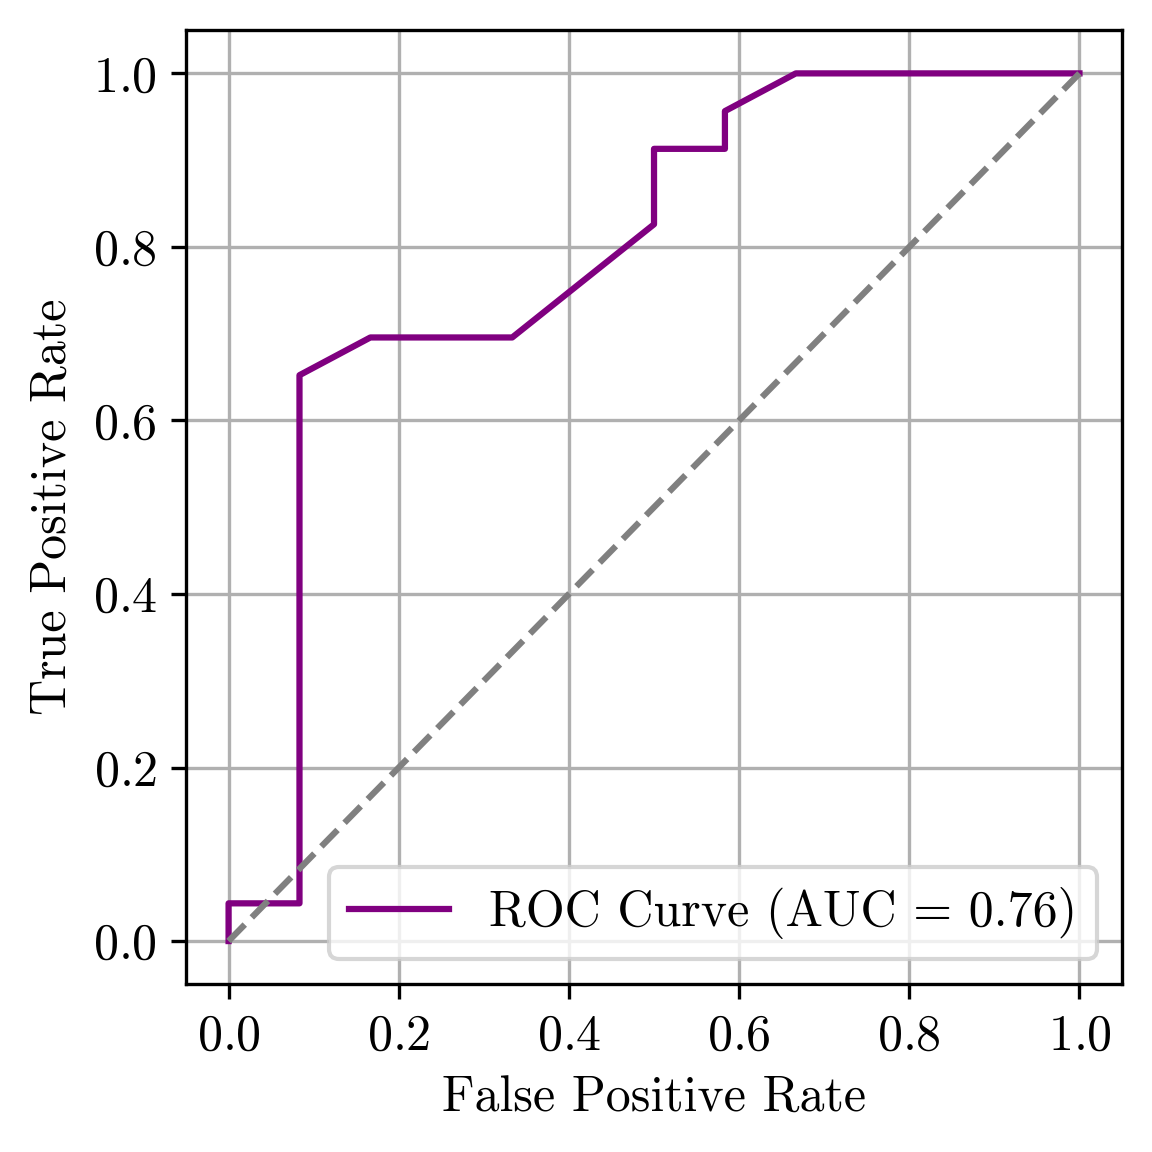

In [5]:
results = np.load('scores_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/scores_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/scores_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate averave ensemble without scores

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        pred_class, output = get_ensemble_prediction_avg(pointnet_output, volumes_output, None, scores=False)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/avgensemblenoscores_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

              precision    recall  f1-score   support

          CN       0.54      0.50      0.52        60
         MCI       0.75      0.77      0.76       115

    accuracy                           0.68       175
   macro avg       0.64      0.64      0.64       175
weighted avg       0.68      0.68      0.68       175

roc_auc: 0.6369565217391304
specificity: 0.5


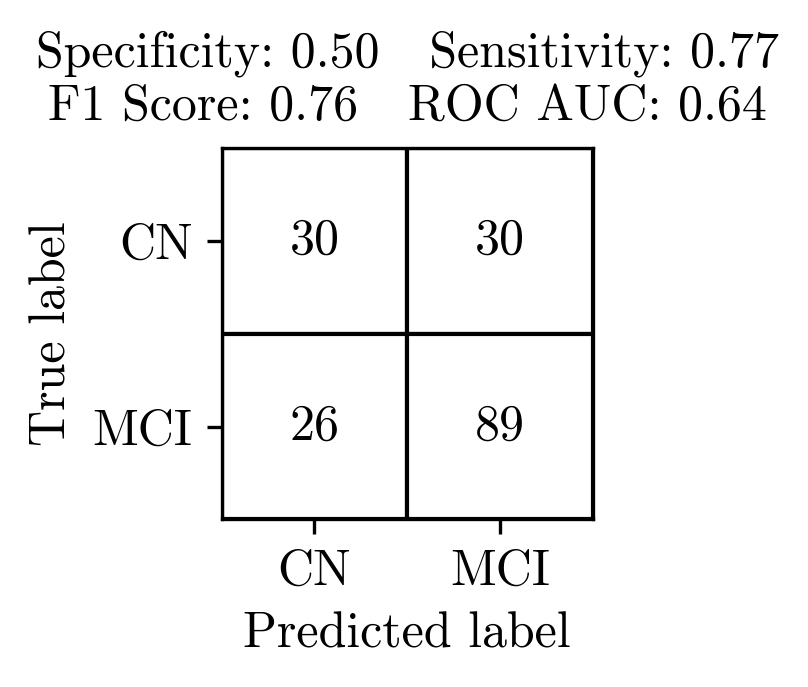

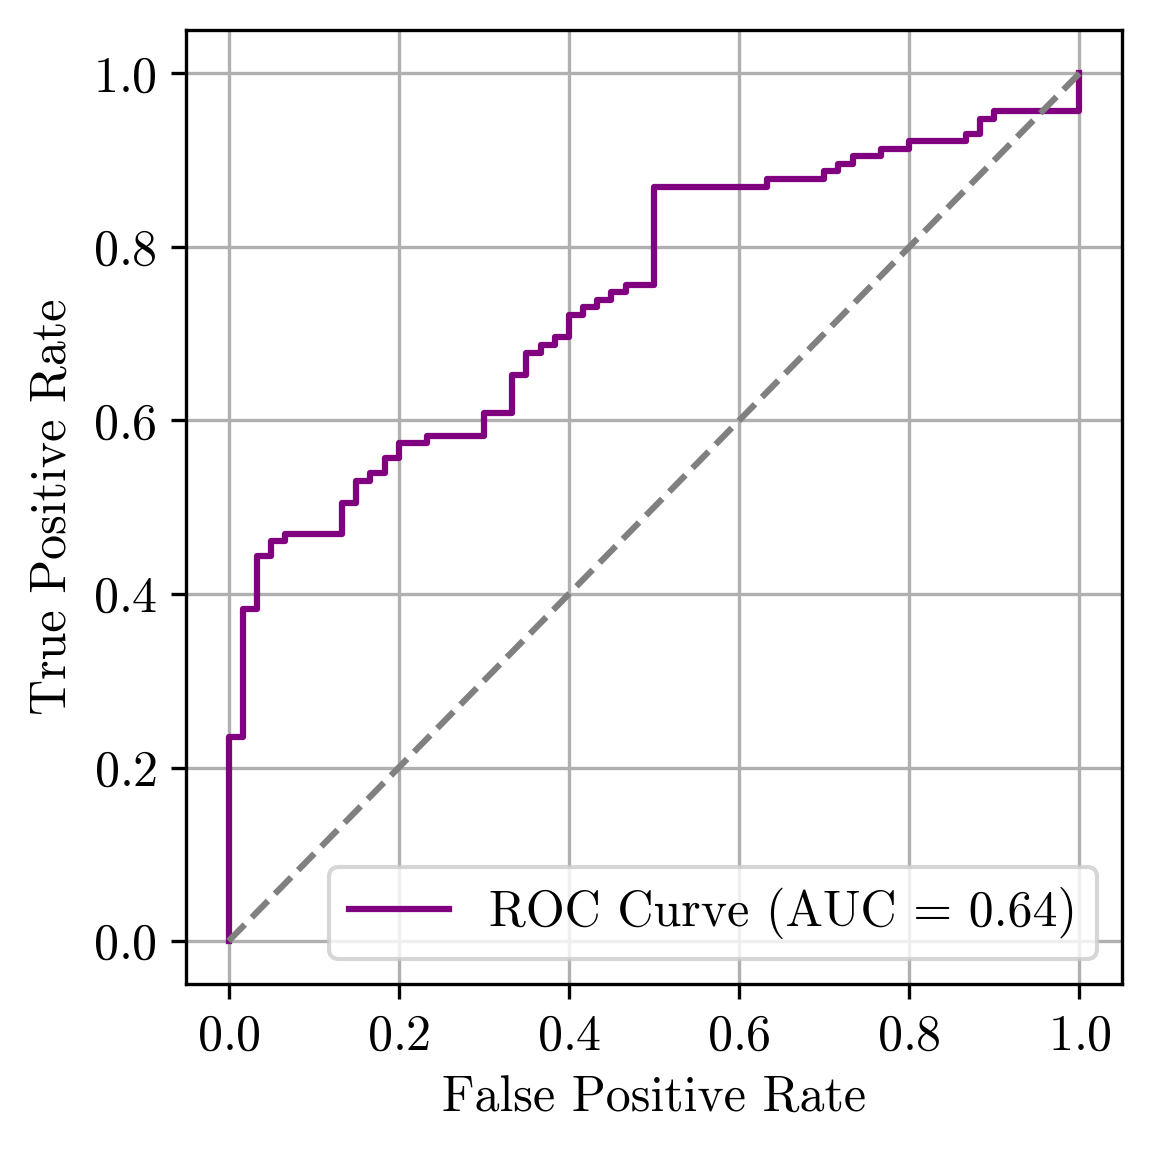

In [6]:
results = np.load('avgensemblenoscores_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/avgensemblenoscores_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/avgensemblenoscores_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluate maxprob ensemble without scores

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []
models_used = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        pred_class, output, index = get_ensemble_prediction_maxprob((pointnet_pred_class, pointnet_output), (volumes_pred_class, volumes_output), None, scores=False)

        models_used.append(index)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

print(np.unique(models_used, return_counts=True))

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/maxprobensemblenoscores_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

              precision    recall  f1-score   support

          CN       0.60      0.50      0.55        60
         MCI       0.76      0.83      0.79       115

    accuracy                           0.71       175
   macro avg       0.68      0.66      0.67       175
weighted avg       0.71      0.71      0.71       175

roc_auc: 0.6630434782608696
specificity: 0.5


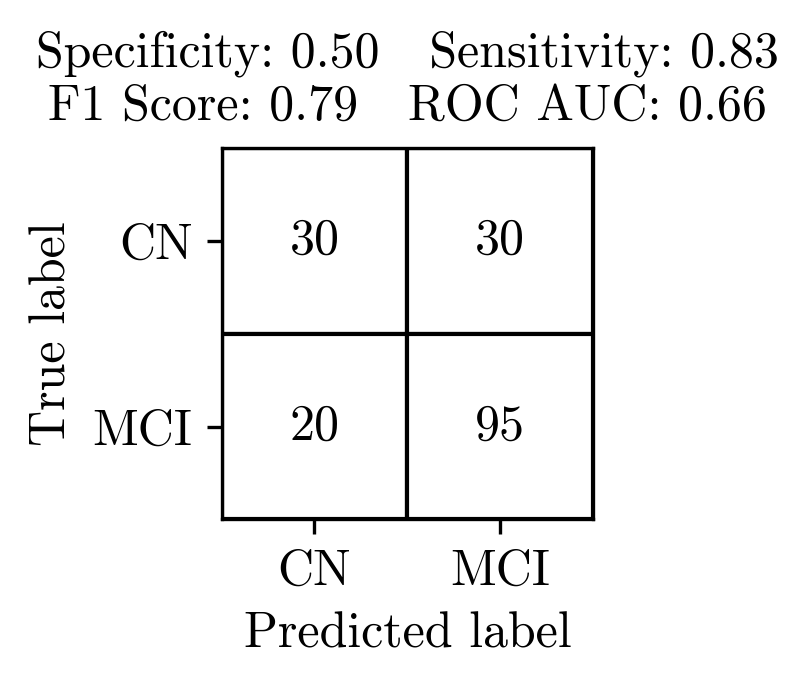

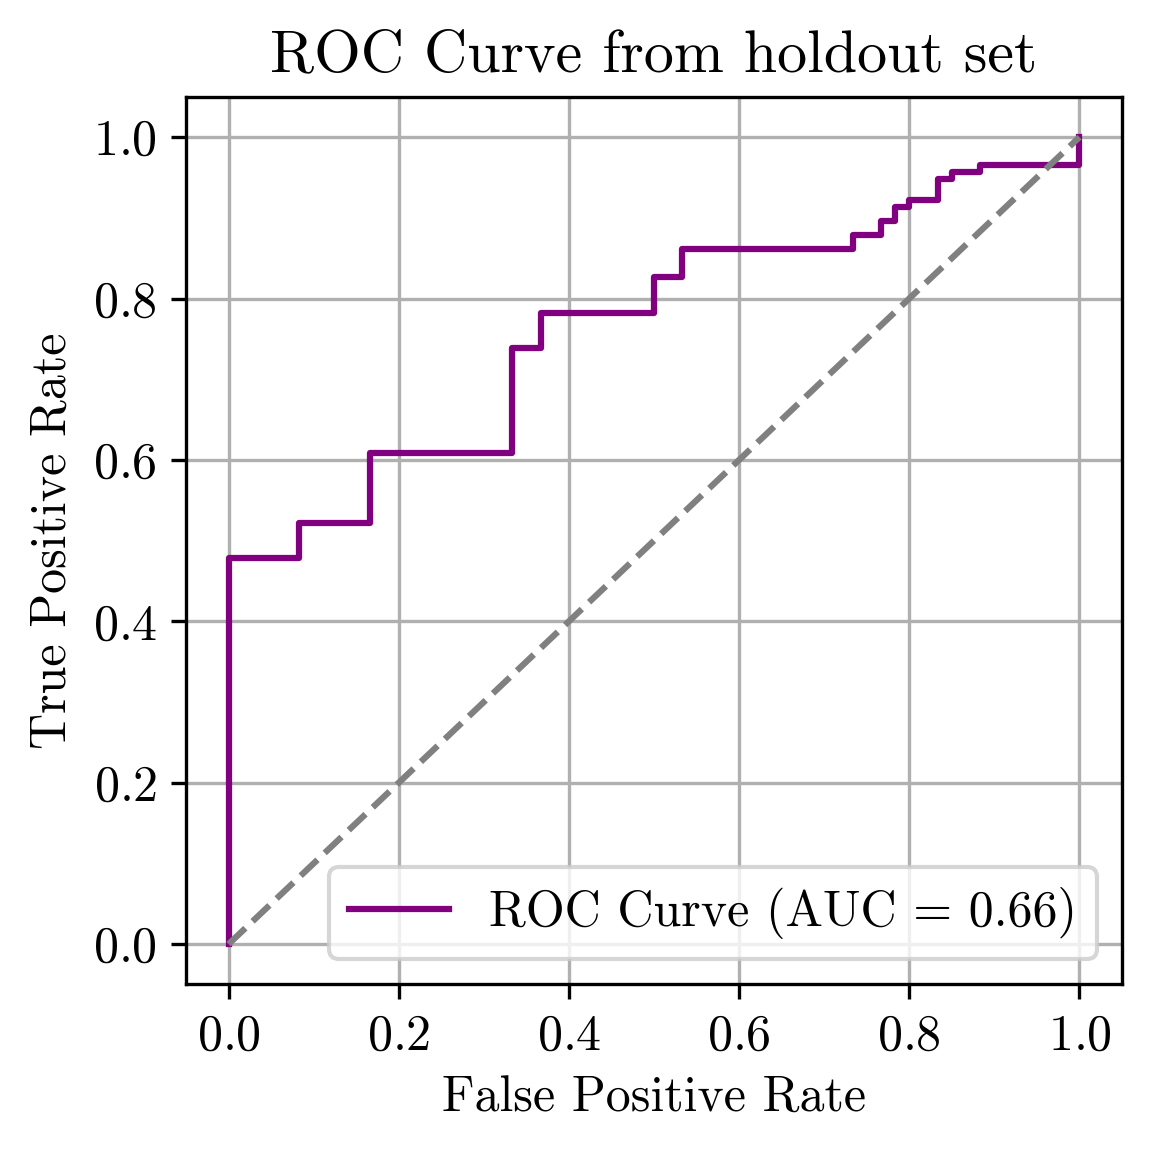

In [7]:
results = np.load('maxprobensemblenoscores_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/maxprobensemblenoscores_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from holdout set')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/maxprobensemblenoscores_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# Evaluate averave ensemble with scores

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        scores_pred_class, scores_output = get_scores_prediction(subject.data['scores'])

        pred_class, output = get_ensemble_prediction_avg(pointnet_output, volumes_output, scores_output, scores=True)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/avgensemble_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

              precision    recall  f1-score   support

          CN       0.56      0.67      0.61        60
         MCI       0.81      0.72      0.76       115

    accuracy                           0.70       175
   macro avg       0.68      0.69      0.68       175
weighted avg       0.72      0.70      0.71       175

roc_auc: 0.6942028985507248
specificity: 0.6666666666666666


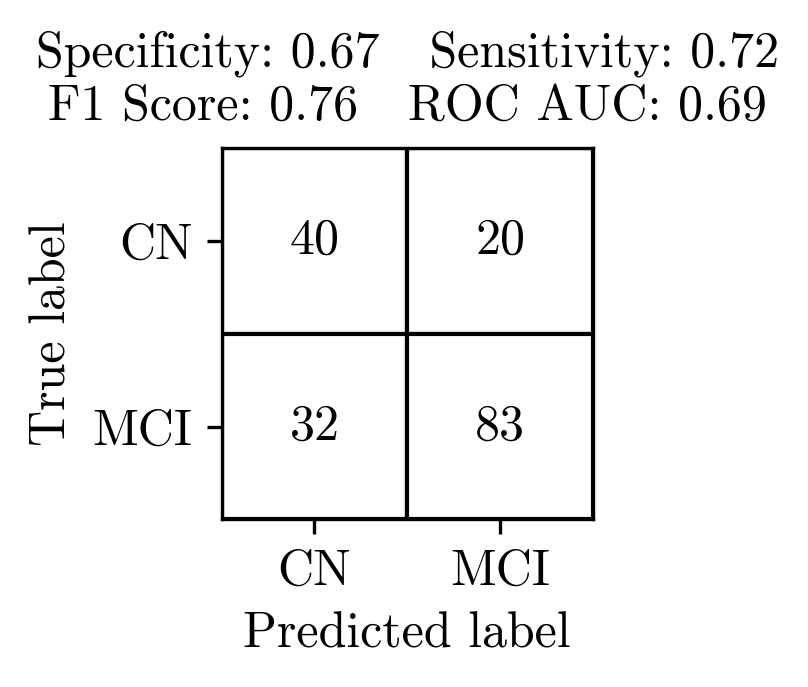

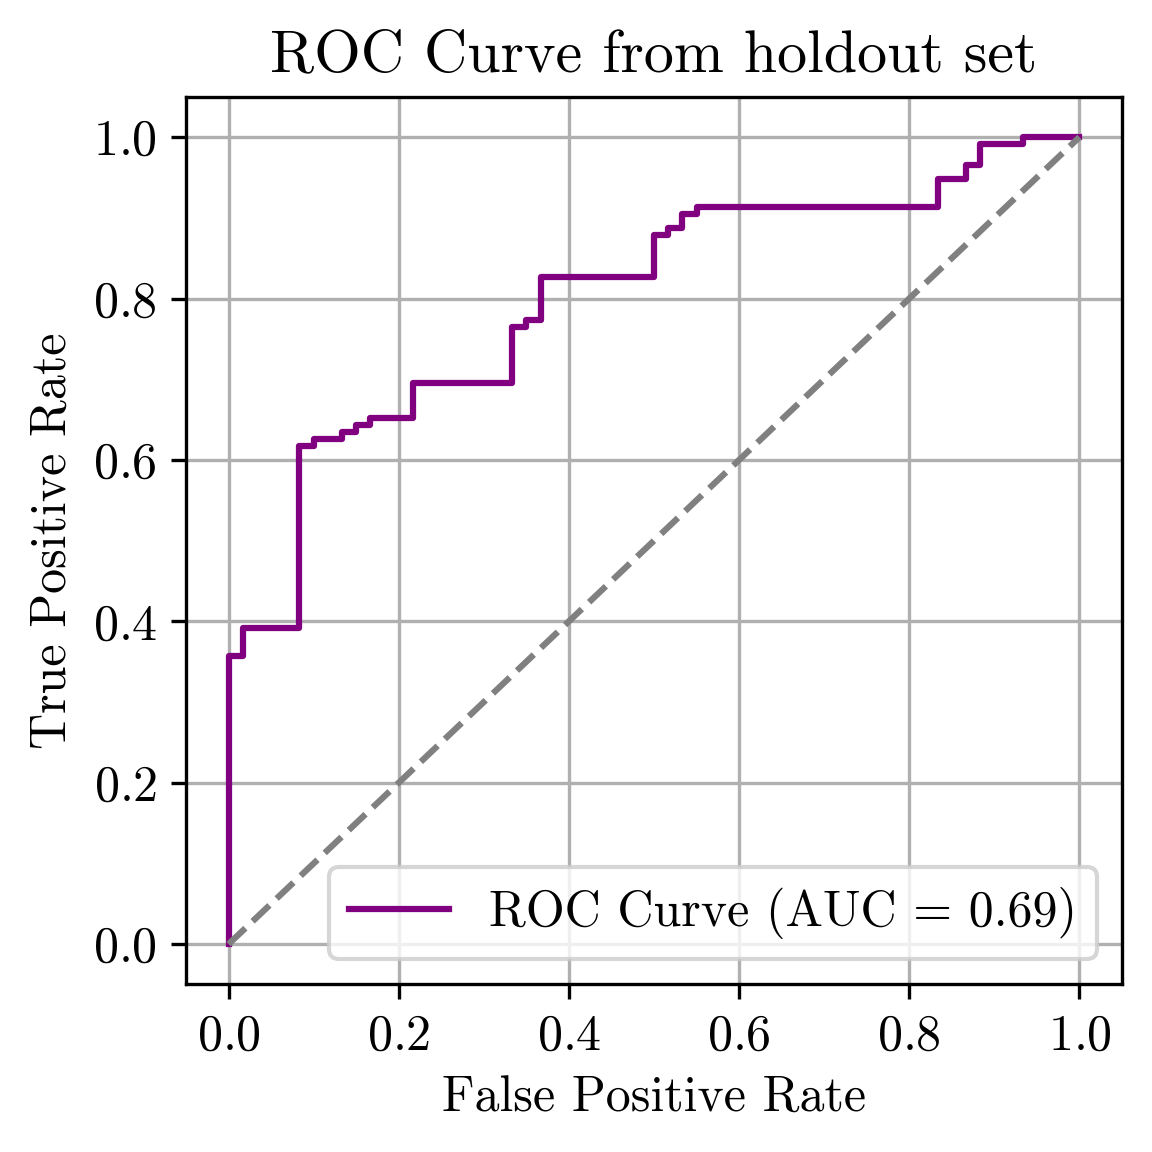

In [8]:
results = np.load('avgensemble_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/avgensemble_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from holdout set')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/avgensemble_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluate maxprob ensemble with scores

In [ ]:
true = []
pred_probs = []
pred_classes = []
data = []
models_used = []

# Run multiple times to account for randomness
for i in range(5):

    for subject in tqdm(subject_list, total=len(subject_list)):

        pointnet_pred_class, pointnet_output, attributions = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cuda')

        volumes_pred_class, volumes_output, shap_values = get_volumes_prediction(subject.data['volumes'], subject.data['struct_names'])

        scores_pred_class, scores_output = get_scores_prediction(subject.data['scores'])

        pred_class, output, index = get_ensemble_prediction_maxprob((pointnet_pred_class, pointnet_output), (volumes_pred_class, volumes_output), (scores_pred_class, scores_output), scores=True)

        models_used.append(index)

        data.append(subject.data['volumes'])

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

print(np.unique(models_used, return_counts=True))

np.savez('/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/maxprobensemble_eval.npz', true=true, pred_probs=pred_probs, pred_classes=pred_classes, data=data)

              precision    recall  f1-score   support

          CN       0.62      0.42      0.50        60
         MCI       0.74      0.87      0.80       115

    accuracy                           0.71       175
   macro avg       0.68      0.64      0.65       175
weighted avg       0.70      0.71      0.70       175

roc_auc: 0.6431159420289855
specificity: 0.4166666666666667


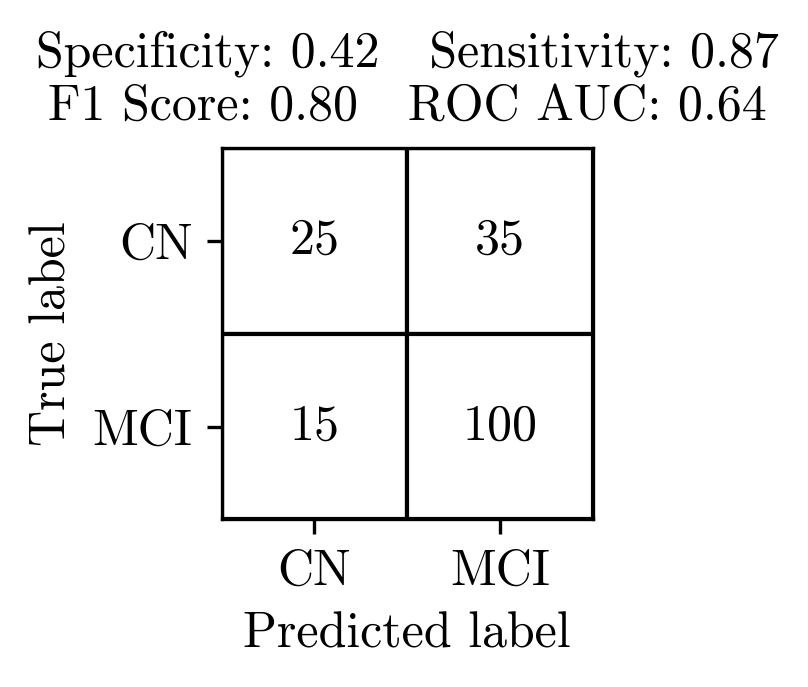

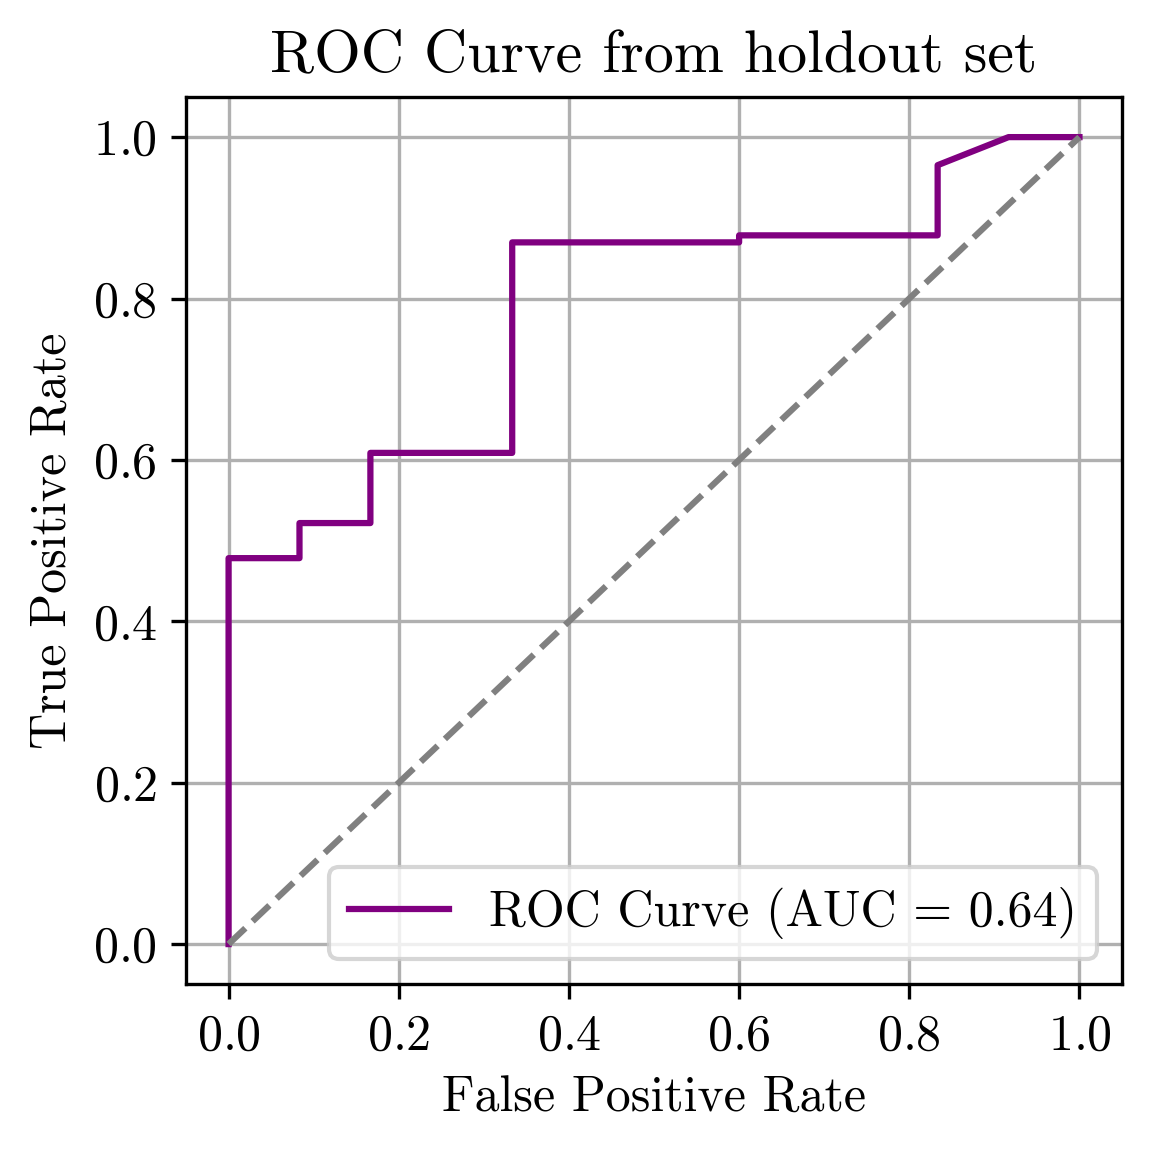

In [9]:
results = np.load('maxprobensemble_eval.npz')
true = results['true']
pred_probs = results['pred_probs']
pred_classes= results['pred_classes']
data= results['data']

report = classification_report(true, pred_classes, target_names=['CN', 'MCI'], output_dict=True)

print(classification_report(true, pred_classes, target_names=['CN', 'MCI']))

roc_auc = roc_auc_score(true, pred_classes)

print(f"roc_auc: {roc_auc}")
print(f"specificity: {recall_score(true, pred_classes, pos_label=0)}")

fpr, tpr, thresholds = roc_curve(true, pred_probs)

conf_matrix = confusion_matrix(true, pred_classes)

labels = ['CN', 'MCI']
fig, ax = plt.subplots(dpi=300, figsize=(2.5, 2.5))
num_classes = conf_matrix.shape[0]
ax.set_xlim(-0.5, num_classes - 0.5)
ax.set_ylim(num_classes - 0.5, -0.5)
ax.set_aspect('equal')
for i in range(num_classes):
    for j in range(num_classes):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                             fill=True, edgecolor='black', facecolor='white')
        ax.add_patch(rect)
        ax.text(j, i, str(conf_matrix[i, j]),
                ha='center', va='center', color='black', fontsize=12)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
metrics_text = f'Specificity: {recall_score(true, pred_classes, pos_label=0):.2f}   Sensitivity: {report['MCI']['recall']:.2f}\nF1 Score: {report['MCI']['f1-score']:.2f}   ROC AUC: {roc_auc:.2f}'
ax.text(num_classes / 2 - 0.5, -0.6, metrics_text,
        ha='center', va='bottom')
plt.tight_layout()
plt.savefig('figures/maxprobensemble_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(dpi=300, figsize=(4, 4))
ax.plot(fpr, tpr, color='purple', label=f'ROC Curve (AUC = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
ax.set_title('ROC Curve from holdout set')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig('figures/maxprobensemble_roc.png', dpi=300, bbox_inches='tight')
plt.show()

## 